# Quora Question Pairs
https://www.kaggle.com/c/quora-question-pairs

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [34]:
df = pd.read_csv('../Data/train.csv')

In [35]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We don't have a lot of columns in this dataset.  
**id**: this is the id of the pair.  
**qid1** and **qid2**: those are the ids of question 1 and question 2. They seem to be ids given for this particular dataset and are not related to quora's question id.  
**question1** and **question2**: this is the text of the questions.  
**is_duplicate**: this is the label we'll have to predict. 1 if the pair is a duplicate. 0 otherwise.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [37]:
def feature_chart(dataframe, count, group):
    df = dataframe.groupby([count, group])[group].count().unstack(count)
    df.fillna(0, inplace=True)
    df['percent_duplicate'] = (df[1] / (df[0] + df[1])) * 100
    print(df)
    #df[[0,1]].plot(kind='bar', stacked=True) 
    df['percent_duplicate'].plot(kind='bar')

In [38]:
# class balance
df.groupby('is_duplicate').size()

is_duplicate
0    255027
1    149263
dtype: int64

We're having an imbalanced dataset that will require resampling.  
## Characters count
I want to count the difference in the number of characters between question1 and question2.  
Then I will look for a correlation between this value and the label.

In [39]:
# comparing the questions length and check for correlation with labels
df['char_count1'] = df['question1'].apply(lambda x: len(x))
df['char_count2'] = df['question2'].apply(lambda x: len(str(x)))
df['char_diff'] = abs(df['char_count1'] - df['char_count2'])
df['char_diff'].describe()
#df['char_diff'].plot(kind='bar')

count    404290.000000
mean         20.158179
std          25.584401
min           0.000000
25%           4.000000
50%          12.000000
75%          26.000000
max        1080.000000
Name: char_diff, dtype: float64

{'boxes': [<matplotlib.lines.Line2D at 0x7efc27b1a6a0>],
 'caps': [<matplotlib.lines.Line2D at 0x7efc27b22a20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc27b31940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efc27b29a90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efc27b1af60>,
  <matplotlib.lines.Line2D at 0x7efc27b22860>]}

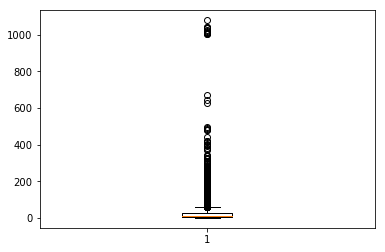

In [40]:
plt.boxplot(df.char_diff)

In [41]:
# I want to visualize the part of duplicates per character count difference
# I group characters count differences in bins
#df['char_diff_bins'] = pd.cut(df.char_diff,100)

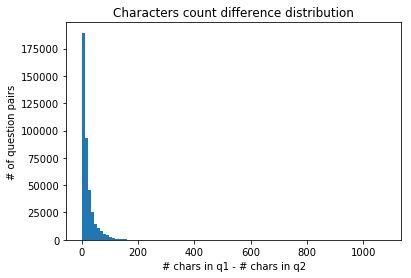

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df.char_diff, bins=100)
plt.title('Characters count difference distribution')
plt.xlabel('# chars in q1 - # chars in q2')
plt.ylabel('# of question pairs')
plt.show()

I will keep only the pairs that have a difference between -200 and +200

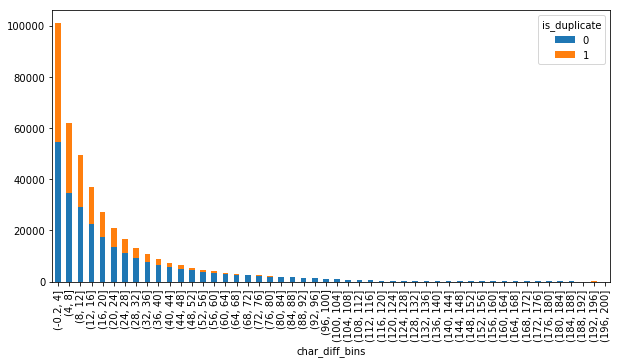

In [ ]:
df_char = df[['char_diff','is_duplicate']]
df_char = df_char[(df_char['char_diff'] >= 0) & (df_char['char_diff'] <= 200)]
df_char['char_diff_bins'] = pd.cut(df_char.char_diff,50)
df_char = df_char.groupby(['char_diff_bins','is_duplicate'])['char_diff_bins'].count().unstack('is_duplicate')
#df_char['duplicate_pct'] = (df_char[1] / (df_char[0] + df_char[1])) * 100

fig, ax = plt.subplots(figsize=(10,5))
ax = df_char[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.show()

## Words count
I am going to do the same exercise than before but I will count words instead of characters.

In [ ]:
# comparing words count
df['tokens1'] = df['question1'].apply(lambda x: nltk.word_tokenize(x))
df['word_count1'] = df['tokens1'].apply(lambda x: len(x))
df['tokens2'] = df['question2'].apply(lambda x: nltk.word_tokenize(str(x)))
df['word_count2'] = df['tokens2'].apply(lambda x: len(x))
df.head()

In [ ]:
df['word_diff'] = abs(df['word_count1'] - df['word_count2'])
df['word_diff'].describe()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df.word_diff, bins=100)
plt.title('Words count difference distribution')
plt.xlabel('|# words in q1 - # words in q2|')
plt.ylabel('# of question pairs')
plt.show()

In [ ]:
df_word = df[['word_diff','is_duplicate']]
df_word = df_word[(df_word['word_diff'] >= 0) & (df_word['word_diff'] <= 25)]
df_word['word_diff_bins'] = pd.cut(df_word.word_diff,25)
df_word = df_word.groupby(['word_diff_bins','is_duplicate'])['word_diff_bins'].count().unstack('is_duplicate')

fig, ax = plt.subplots(figsize=(10,5))
ax = df_word[[0,1]].plot(kind='bar', stacked=True, ax=ax) 
plt.show()

## question words
I want to extract the question word from each question and look at the impact of different words used in the pair.

In [ ]:
question_words = ['what','where','when','why','who','which','whose','how']
def get_qword(string):
    string = str(string).lower()
    for word in question_words:
        if word in string:
            return word
        
df['qword1'] = df['question1'].apply(lambda x: get_qword(x))
df['qword2'] = df['question2'].apply(lambda x: get_qword(x))
df['qword_diff'] = df.apply(lambda row: False if row['qword1'] == row['qword2'] else True)
df.head()

In [ ]:
df.columns